In [8]:
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
from io import StringIO



In [2]:
# URL of the XML file
xml_file_path = r'.\benteng.xml'
xml_file = open(xml_file_path)

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()



In [3]:
# Initialize lists to store data
parameter_ids = []
descriptions = []
types = []
hours = []
datetimes = []
values = []
value_units = []

# Extract data from XML and store in lists
for parameter in root.findall('parameter'):
    parameter_id = parameter.attrib['id']
    description = parameter.attrib['description']
    param_type = parameter.attrib['type']
    if parameter_id in ['wd', 'ws']:
        for timerange in parameter.findall('timerange'):
            parameter_ids.append(parameter_id)
            descriptions.append(description)
            types.append(param_type)
            hours.append(timerange.attrib['h'])
            datetimes.append(timerange.attrib['datetime'])
            value = timerange.find('value')
            converted_value = float(value.text) * 0.514444 if parameter_id == 'ws' and value.attrib['unit'] == 'Kt' else float(value.text)
            unit = 'MS' if parameter_id == 'ws' else value.attrib['unit']
            values.append(converted_value)
            value_units.append(unit)

# Create a DataFrame from the extracted data
df = pd.DataFrame({
    'parameter_id': parameter_ids,
    'description': descriptions,
    'type': types,
    'hour': hours,
    'datetime': datetimes,
    'value': values,
    'value_unit': value_units
})

# Display the DataFrame
print(df)

   parameter_id     description    type hour      datetime      value  \
0            wd  Wind direction  hourly    0  202403160000  292.50000   
1            wd  Wind direction  hourly    6  202403160600  292.50000   
2            wd  Wind direction  hourly   12  202403161200  292.50000   
3            wd  Wind direction  hourly   18  202403161800  292.50000   
4            wd  Wind direction  hourly   24  202403170000  292.50000   
5            wd  Wind direction  hourly   30  202403170600  292.50000   
6            wd  Wind direction  hourly   36  202403171200  292.50000   
7            wd  Wind direction  hourly   42  202403171800  292.50000   
8            wd  Wind direction  hourly   48  202403180000  292.50000   
9            wd  Wind direction  hourly   54  202403180600  292.50000   
10           wd  Wind direction  hourly   60  202403181200  292.50000   
11           wd  Wind direction  hourly   66  202403181800  292.50000   
12           ws      Wind speed  hourly    0  20240

In [4]:
BMKG_pulau_selayar = pd.DataFrame()

wind_speed_df = df[df['parameter_id'] == 'ws'][['hour', 'value']]
wind_direction_df = df[df['parameter_id'] == 'wd'][['hour', 'value']]
timestamp_df = df[df['parameter_id'] == 'wd']['datetime']

BMKG_pulau_selayar = pd.merge(wind_speed_df, wind_direction_df, on='hour', suffixes=('_speed', '_direction'))
BMKG_pulau_selayar.columns = ['hour', 'wind_speed', 'wind_direction']

BMKG_pulau_selayar['timestamp'] = timestamp_df
BMKG_pulau_selayar

,hour,wind_speed,wind_direction,timestamp
0,0,7.71666,292.5,202403160000
1,6,7.71666,292.5,202403160600
2,12,7.71666,292.5,202403161200
3,18,7.71666,292.5,202403161800
4,24,7.71666,292.5,202403170000
5,30,10.28888,292.5,202403170600
6,36,7.71666,292.5,202403171200
7,42,7.71666,292.5,202403171800
8,48,7.71666,292.5,202403180000
9,54,12.86110,292.5,202403180600


In [5]:
NSRDB = pd.read_csv(r'.\data pulau selayar\pulau selayar.csv')

print(NSRDB)

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
0     2020      1    1     0       0         26.9         103.0         718.0   
1     2020      1    1     1       0         26.9         116.0         826.0   
2     2020      1    1     2       0         26.9         123.0         884.0   
3     2020      1    1     3       0         27.0         128.0         912.0   
4     2020      1    1     4       0         27.1         127.0         925.0   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8779  2020     12   31    19       0         25.0           0.0           0.0   
8780  2020     12   31    20       0         25.1           0.0           0.0   
8781  2020     12   31    21       0         25.2           0.0           0.0   
8782  2020     12   31    22       0         25.4          15.0         206.0   
8783  2020     12   31    23       0         25.7          50.0         661.0   

      Clearsky GHI  Cloud T

In [6]:
wind_speed_2 = NSRDB["Wind Speed"]
wind_direction_2 = NSRDB["Wind Direction"]
hour_2 = NSRDB["Hour"]

wind_speed_data_frame = pd.DataFrame()
wind_speed_data_frame["hour"] = hour_2
wind_speed_data_frame["wind speed"] = wind_speed_2
wind_speed_data_frame["wind direction"] = wind_direction_2

wind_speed_data_frame["timestamp"] = NSRDB["Year"].astype(str) + NSRDB["Month"].map(lambda x: "0" + str(x) if x < 10 else str(x)) + NSRDB["Day"].map(lambda x: "0" + str(x) if x < 10 else str(x))
wind_speed_data_frame


,hour,wind speed,wind direction,timestamp
0,0,4.1,281.0,20200101
1,1,4.1,265.0,20200101
2,2,4.2,257.0,20200101
3,3,4.3,262.0,20200101
4,4,4.5,266.0,20200101
...,...,...,...,...
8779,19,1.0,227.0,20201231
8780,20,1.0,210.0,20201231
8781,21,1.1,199.0,20201231
8782,22,1.2,201.0,20201231


In [7]:
# friction velocity 

# u(z) = u*/k ln(z/zo)

zo = 1.5 # daerah hutan
k = 0.4 # karman constant
z = 2

wind_speed_data_frame["friction velocity"] = wind_speed_data_frame["wind speed"] * k /(np.log(z/zo))
# wind_speed_data_frame["timestamp"] = pd.to_datetime(wind_speed_data_frame["timestamp"], format='%Y%m%d')
# wind_speed_data_frame["index"] = wind_speed_data_frame['timestamp'].astype(str) + '-' + wind_speed_data_frame['hour'].map(lambda x: "0" + str(x) if x < 10 else str(x)) + [".00"]*len(wind_speed_data_frame.index)
wind_speed_data_frame = wind_speed_data_frame.set_index(['timestamp', 'hour'])
wind_speed_data_frame

wind speed  wind direction  friction velocity
timestamp hour                                               
20200101  0            4.1           281.0           5.700738
          1            4.1           265.0           5.700738
          2            4.2           257.0           5.839780
          3            4.3           262.0           5.978822
          4            4.5           266.0           6.256907
...                    ...             ...                ...
20201231  19           1.0           227.0           1.390424
          20           1.0           210.0           1.390424
          21           1.1           199.0           1.529466
          22           1.2           201.0           1.668509
          23           1.5           209.0           2.085636

[8784 rows x 3 columns]

In [8]:
wind_speed_data_frame.xs(6, level = 1)

,wind speed,wind direction,friction velocity
timestamp,,,
20200101,4.9,262.0,6.813077
20200102,5.4,259.0,7.508289
20200103,7.8,279.0,10.845306
20200104,4.5,288.0,6.256907
20200105,4.8,307.0,6.674034
...,...,...,...
20201227,4.1,261.0,5.700738
20201228,4.1,283.0,5.700738
20201229,2.9,302.0,4.032229


setelah dibandingkan dengan data BMKG didapat bahwa kecepatan angin mengikuti power law dengan profil mirip turbulen

In [9]:
# wind speed at 10 m
alpha = 0.2331 
z0 = 2 
z1 = 10 
wind_speed_data_frame['wind speed_10 m'] = wind_speed_data_frame['wind speed']/((z0/z1)**alpha)
wind_speed_data_frame['wind direction_10 m'] = wind_speed_data_frame["wind direction"]
wind_speed_data_frame

wind speed  wind direction  friction velocity  \
timestamp hour                                                  
20200101  0            4.1           281.0           5.700738   
          1            4.1           265.0           5.700738   
          2            4.2           257.0           5.839780   
          3            4.3           262.0           5.978822   
          4            4.5           266.0           6.256907   
...                    ...             ...                ...   
20201231  19           1.0           227.0           1.390424   
          20           1.0           210.0           1.390424   
          21           1.1           199.0           1.529466   
          22           1.2           201.0           1.668509   
          23           1.5           209.0           2.085636   

                wind speed_10 m  wind direction_10 m  
timestamp hour                                        
20200101  0            5.966419                281.0  
          1            5.966419                265.0  
          2            6.111942                257.0  
          3            6.257464                262.0  
          4            6.548509                266.0  
...                         ...                  ...  
20201231  19           1.455224                227.0  
          20           1.455224                210.0  
          21           1.600747                199.0  
          22           1.746269                201.0  
          23           2.182836                209.0  

[8784 rows x 5 columns]

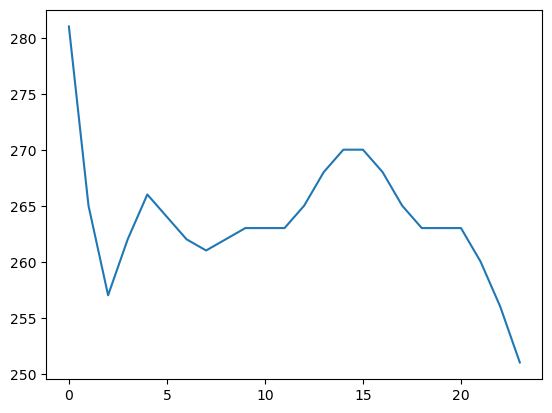

In [10]:
time_20200101_df = wind_speed_data_frame.loc['20200101']
time_20200101_df

plt.plot(time_20200101_df.index, time_20200101_df['wind direction'])

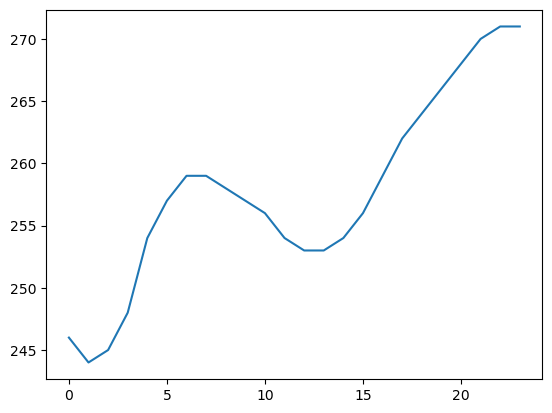

In [11]:
time_20200101_df = wind_speed_data_frame.loc['20200102']
time_20200101_df

plt.plot(time_20200101_df.index, time_20200101_df['wind direction'])

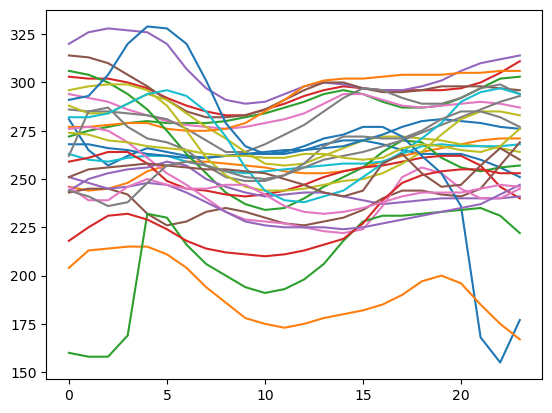

In [12]:
for i in range(1, 30):
    time_20200101_df = wind_speed_data_frame.loc['202001' + (('0'+ str(i)) if i < 10 else str(i))]
    plt.plot(time_20200101_df.index, time_20200101_df['wind direction'])

In [13]:
wind_speed_data_frame["wind speed"].max()

8.5

In [ ]:
wind_speed_data_frame.to_csv('data kecepatan wind di pulau selayar.csv', encoding='utf-8')

In [15]:
# Read the text file
with open(r'C:\Users\ricky\Documents\UI\Semester 2\wind energy\Exercise 2\vortex.serie.733611.6m 10m UTC+08.0 CFSR.txt', 'r') as file:
    lines = file.readlines()

# Remove the first two lines
lines = lines[2:]

# Join the remaining lines
data = "\n".join(lines)

# Create a DataFrame from the text
vortex_10m = pd.read_csv(StringIO(data), delim_whitespace=True)

# Save the DataFrame to a CSV file
vortex_10m.to_csv('vortex_10m.csv', index=False)


C:\Users\ricky\AppData\Local\Temp\ipykernel_27632\1849392443.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  vortex_10m = pd.read_csv(StringIO(data), delim_whitespace=True)


C:\Users\ricky\AppData\Local\Temp\ipykernel_27632\3278407642.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  vortex_10m = pd.read_csv(StringIO(data), delim_whitespace=True)
